# Importing the dataset

In [1]:
import pandas as pd 
import numpy as np
import pandasql as ps
import os
import re
import random 
import numpy as np
import warnings
import tensorflow as tf 
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import make_column_transformer
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from preprocess_days_stats import preprocess_match_days
from preprocess_time_serie import preprocess_teams, create_time_series_features
from preprocess_time_series_features import preprocess_features_time_series, create_fast_preprocessing_ts
from create_models_time_series import create_time_series_model_dense, create_time_series_model_lstm
from helper_functions_tensorflow import CSVLoggerCallback, CSVLoggerCallbackParams, plot_loss_curve

# Ignora tutti i warning temporaneamente
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

df_giornate = preprocess_match_days(r"c:\Users\Hp\Documents\Serie_A_dump\csv_serie_a")

Reading file: I1 (0).csv
Reading file: I1 (1).csv
Reading file: I1 (10).csv
Reading file: I1 (11).csv
Reading file: I1 (12).csv
Reading file: I1 (13).csv
Reading file: I1 (14).csv
Reading file: I1 (15).csv
Reading file: I1 (16).csv
Reading file: I1 (17).csv
Reading file: I1 (18).csv
Reading file: I1 (2).csv
Reading file: I1 (3).csv
Reading file: I1 (4).csv
Reading file: I1 (5).csv
Reading file: I1 (6).csv
Reading file: I1 (7).csv
Reading file: I1 (8).csv
Reading file: I1 (9).csv
preprocessing finished!


In [2]:
df_giornate.head()

,div,giornata,stagione,date,hometeam,awayteam,ft_home_goals,ft_away_goals,ft_result,ht_home_goals,ht_away_goals,ht_results,home_shots,away_shots,home_shots_targ,away_shots_targ,home_fouls,away_fouls,home_corners,away_corners,home_yellow,away_yellow,home_red,away_red,home_win_odds,draw_odds,away_win_odds
0,I1,1,2005/2006,2005-08-27,Fiorentina,Sampdoria,2.0,1.0,H,2.0,0.0,H,15.0,9.0,9.0,4.0,18.0,23.0,9.0,3.0,1.0,4.0,0.0,0.0,2.20,2.87,3.25
1,I1,1,2005/2006,2005-08-27,Livorno,Lecce,2.0,1.0,H,1.0,1.0,D,17.0,6.0,7.0,5.0,27.0,21.0,9.0,2.0,2.0,3.0,0.0,0.0,1.90,2.90,4.00
2,I1,1,2005/2006,2005-08-28,Ascoli,Milan,1.0,1.0,D,0.0,0.0,D,8.0,16.0,3.0,9.0,22.0,16.0,0.0,5.0,2.0,1.0,0.0,0.0,7.50,3.75,1.40
3,I1,1,2005/2006,2005-08-28,Inter,Treviso,3.0,0.0,H,1.0,0.0,H,16.0,7.0,9.0,3.0,13.0,20.0,6.0,1.0,1.0,3.0,0.0,0.0,1.16,5.50,13.00
4,I1,1,2005/2006,2005-08-28,Juventus,Chievo,1.0,0.0,H,1.0,0.0,H,16.0,2.0,7.0,0.0,16.0,12.0,6.0,2.0,1.0,2.0,0.0,0.0,1.25,5.00,13.00


# Data preprocessing

In [3]:
all_features = ['ft_goals','ft_goals_conceded','shots','shots_target', 'fouls_done','corners_obtained', 'yellows', 'reds']
less_features = ['ft_goals','ft_goals_conceded','shots', 'fouls_done','corners_obtained', 'reds']
few_features = ['ft_goals','ft_goals_conceded','shots', 'reds']

In [4]:
num_features = 'all'
Statistiche_squadre_dict = preprocess_teams(dataframe = df_giornate)
df_Serie_A = create_time_series_features(num_features, Statistiche_squadre_dict, df_giornate, 5).dropna()
df_Serie_A[(df_Serie_A['hometeam']=='Lecce') | (df_Serie_A['awayteam']=='Lecce')].head(6)

utilizzando tutte le features
preprocess finished


,div,giornata,stagione,date,hometeam,awayteam,home_ft_goals_1,home_ft_goals_2,home_ft_goals_3,home_ft_goals_4,home_ft_goals_5,home_ft_goals_conceded_1,home_ft_goals_conceded_2,home_ft_goals_conceded_3,home_ft_goals_conceded_4,home_ft_goals_conceded_5,home_shots_1,home_shots_2,home_shots_3,home_shots_4,home_shots_5,home_shots_target_1,home_shots_target_2,home_shots_target_3,home_shots_target_4,home_shots_target_5,home_fouls_done_1,home_fouls_done_2,home_fouls_done_3,home_fouls_done_4,home_fouls_done_5,home_corners_obtained_1,home_corners_obtained_2,home_corners_obtained_3,home_corners_obtained_4,home_corners_obtained_5,home_yellows_1,home_yellows_2,home_yellows_3,home_yellows_4,home_yellows_5,home_reds_1,home_reds_2,home_reds_3,home_reds_4,home_reds_5,away_ft_goals_1,away_ft_goals_2,away_ft_goals_3,away_ft_goals_4,away_ft_goals_5,away_ft_goals_conceded_1,away_ft_goals_conceded_2,away_ft_goals_conceded_3,away_ft_goals_conceded_4,away_ft_goals_conceded_5,away_shots_1,away_shots_2,away_shots_3,away_shots_4,away_shots_5,away_shots_target_1,away_shots_target_2,away_shots_target_3,away_shots_target_4,away_shots_target_5,away_fouls_done_1,away_fouls_done_2,away_fouls_done_3,away_fouls_done_4,away_fouls_done_5,away_corners_obtained_1,away_corners_obtained_2,away_corners_obtained_3,away_corners_obtained_4,away_corners_obtained_5,away_yellows_1,away_yellows_2,away_yellows_3,away_yellows_4,away_yellows_5,away_reds_1,away_reds_2,away_reds_3,away_reds_4,away_reds_5,ft_result,home_win_odds,draw_odds,away_win_odds
55,I1,6,2005/2006,2005-10-02,Lecce,Cagliari,0.0,1.0,0.0,0.0,1.0,1.0,3.0,3.0,0.0,2.0,12.0,10.0,7.0,9.0,6.0,2.0,4.0,5.0,6.0,5.0,24.0,18.0,19.0,18.0,21.0,5.0,2.0,3.0,9.0,2.0,4.0,3.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,2.0,8.0,9.0,16.0,9.0,9.0,3.0,5.0,8.0,3.0,6.0,12.0,16.0,20.0,12.0,19.0,2.0,5.0,8.0,6.0,4.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,H,2.10,3.00,3.75
69,I1,7,2005/2006,2005-10-16,Reggina,Lecce,1.0,2.0,0.0,1.0,2.0,2.0,0.0,1.0,3.0,3.0,8.0,6.0,8.0,16.0,11.0,1.0,4.0,3.0,8.0,7.0,10.0,20.0,19.0,11.0,24.0,1.0,4.0,5.0,5.0,5.0,0.0,4.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,0.0,11.0,12.0,10.0,7.0,9.0,8.0,2.0,4.0,5.0,6.0,24.0,24.0,18.0,19.0,18.0,4.0,5.0,2.0,3.0,9.0,0.0,4.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,H,2.10,2.80,3.50
73,I1,8,2005/2006,2005-10-23,Lecce,Juventus,0.0,3.0,0.0,1.0,0.0,2.0,0.0,1.0,3.0,3.0,9.0,11.0,12.0,10.0,7.0,4.0,8.0,2.0,4.0,5.0,25.0,24.0,24.0,18.0,19.0,3.0,4.0,5.0,2.0,3.0,4.0,0.0,4.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,14.0,8.0,8.0,7.0,17.0,10.0,5.0,6.0,3.0,7.0,24.0,29.0,27.0,18.0,18.0,6.0,1.0,5.0,1.0,8.0,2.0,2.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,A,7.00,3.75,1.50
86,I1,9,2005/2006,2005-10-26,Palermo,Lecce,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,4.0,0.0,8.0,9.0,21.0,10.0,16.0,4.0,6.0,10.0,4.0,10.0,18.0,26.0,13.0,21.0,17.0,6.0,4.0,11.0,7.0,10.0,3.0,3.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,3.0,2.0,0.0,1.0,3.0,5.0,9.0,11.0,12.0,10.0,2.0,4.0,8.0,2.0,4.0,30.0,25.0,24.0,24.0,18.0,9.0,3.0,4.0,5.0,2.0,1.0,4.0,0.0,4.0,3.0,0.0,1.0,0.0,0.0,1.0,H,1.57,3.50,6.50
94,I1,10,2005/2006,2005-10-30,Lecce,Messina,0.0,0.0,0.0,3.0,0.0,3.0,3.0,2.0,0.0,1.0,12.0,5.0,9.0,11.0,12.0,5.0,2.0,4.0,8.0,2.0,16.0,30.0,25.0,24.0,24.0,7.0,9.0,3.0,4.0,5.0,3.0,1.0,4.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,4.0,4.0,14.0,10.0,8.0,18.0,6.0,8.0,3.0,4.0,10.0,3.0,22.0,16.0,26.0,15.0,16.0,3.0,3.0,1.0,5.0,2.0,4.0,3.0,4.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,A,2.00,3.00,3.50
108,I1,11,2005/2006,2005-11-06,Parma,Lecce,0.0,1.0,1.0,1.0,1.0,2.0,1.0,4.0,1.0,3.0,8.0,11.0,9.0,5.0,10.0,5.0,5.0,4.0,2.0,4.0,13.0,15.0,17.0,16.0,22.0,5.0,4.0,5.0,1.0,5.0,1.0,1.0,2.0,3.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,3.0,2.0,0.0,14.0,12.0,5.0,9.0,11.0,6.0,5.0,2.0,4.0,8.0,22.0,16.0,30.0,25.0,24.0,5.0,7.0,9.0,3.0,4.0,2.0,3.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,H,1.80,3.25,4.00


In [5]:
(Train_teams_encoded, Valid_teams_encoded, Test_teams_encoded, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    Train_dict_features_norm, Valid_dict_features_norm, Test_dict_features_norm, 
    Train_teams, Valid_teams, Test_teams, Train_labels, Valid_labels, Test_labels, Train_dict_features, Valid_dict_features, Test_dict_features, 
    Train_odds, Valid_odds, Test_odds) = preprocess_features_time_series(df_Serie_A, num_features, random_state=True)

utilizzando tutte le features
utilizzando tutte le features
utilizzando tutte le features


## Controlliamo che le numeriche tornino tutte

### Caso all features

In [6]:
numero_features = len(all_features)*5*2
numero_features, len(Train_labels), len(Valid_labels), len(Test_labels)

(80, 5066, 758, 181)

In [7]:
for i in (Train_teams_encoded, Valid_teams_encoded, Test_teams_encoded, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    ):
    print(f' shape: {i.shape}')

for i in list(Train_dict_features_norm.keys()):
    print(Train_dict_features_norm[i].shape)

for i in list(Valid_dict_features_norm.keys()):
    print(Valid_dict_features_norm[i].shape)

 shape: (5066, 86)
 shape: (758, 86)
 shape: (181, 86)
 shape: (5066, 3)
 shape: (758, 3)
 shape: (181, 3)
(5066, 10)
(5066, 10)
(5066, 10)
(5066, 10)
(5066, 10)
(5066, 10)
(5066, 10)
(5066, 10)
(758, 10)
(758, 10)
(758, 10)
(758, 10)
(758, 10)
(758, 10)
(758, 10)
(758, 10)


## Creting fast preprocessing datasets

In [8]:
Train_labels_encoded

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [9]:
Dataset_train_norm, Dataset_valid_norm, Dataset_test_norm = create_fast_preprocessing_ts(Train_teams_encoded, Train_dict_features_norm, Train_labels_encoded,
                                                                                         Valid_teams_encoded, Valid_dict_features_norm,
                                                                    Valid_labels_encoded,Test_teams_encoded, Test_dict_features_norm,Test_labels_encoded )

In [10]:

# #creo i fast preprocessing datasets
# Dataset_train_norm = tf.data.Dataset.from_tensor_slices(Train_dict_features_norm[list(Train_dict_features_norm.keys())[0]])
# for feature in list(Train_dict_features_norm.keys())[1:]:
#     temp_dataset = tf.data.Dataset.from_tensor_slices(Train_dict_features_norm[feature])
#     Dataset_train_norm = tf.data.Dataset.zip((Dataset_train_norm, temp_dataset))
# Train_labels_encoded = tf.data.Dataset.from_tensor_slices(Train_labels_encoded) # make labels
# Dataset_train_norm = tf.data.Dataset.zip((Dataset_train_norm, Train_labels_encoded))

# #creo un array con le features concatenate
# Dataset_Valid_norm = tf.data.Dataset.from_tensor_slices(Valid_dict_features_norm[list(Valid_dict_features_norm.keys())[0]])
# for feature in list(Valid_dict_features_norm.keys())[1:]:
#     temp_dataset = tf.data.Dataset.from_tensor_slices(Valid_dict_features_norm[feature])
#     Dataset_Valid_norm = tf.data.Dataset.zip((Dataset_Valid_norm, temp_dataset))
# Valid_labels_encoded = tf.data.Dataset.from_tensor_slices(Valid_labels_encoded) # make labels
# Dataset_Valid_norm = tf.data.Dataset.zip((Dataset_Valid_norm, Valid_labels_encoded))

# #creo un array con le features concatenate
# Dataset_Test_norm = tf.data.Dataset.from_tensor_slices(Test_dict_features_norm[list(Test_dict_features_norm.keys())[0]])
# for feature in list(Test_dict_features_norm.keys())[1:]:
#     temp_dataset = tf.data.Dataset.from_tensor_slices(Test_dict_features_norm[feature])
#     Dataset_Test_norm = tf.data.Dataset.zip((Dataset_Test_norm, temp_dataset))
# Test_labels_encoded = tf.data.Dataset.from_tensor_slices(Test_labels_encoded) # make labels
# Dataset_Test_norm = tf.data.Dataset.zip((Dataset_Test_norm, Test_labels_encoded))

# Dataset_train_norm = Dataset_train_norm.batch(32).prefetch(tf.data.AUTOTUNE) #Autotune è per dirgli di prefetchare tanti dati quanti può
# Dataset_valid_norm = Dataset_Valid_norm.batch(32).prefetch(tf.data.AUTOTUNE)
# Dataset_Test_norm = Dataset_Test_norm.batch(32).prefetch(tf.data.AUTOTUNE)

## Create CSVLoggerCallback

In [11]:
import csv 

class CSVLoggerCallbackDropout(tf.keras.callbacks.Callback):
    def __init__(self, filename, experiment_name, first_dropout, second_dropout,concat_dropout_1,concat_dropout_2, overwrite= False):
        self.filename = filename
        self.experiment_name = experiment_name
        self.first_dropout = first_dropout 
        self.second_dropout = second_dropout
        self.concat_dropout_1 = concat_dropout_1
        self.concat_dropout_2 = concat_dropout_2
        self.fieldnames = ['experiment', 'first_dropout','second_dropout','concat_dropout_1','concat_dropout_2','epoch',
                                    'loss', 'accuracy','val_loss','val_accuracy']  # Aggiungi altre metriche secondo necessità
        self.first_time = overwrite
        self.best_val_loss = float('inf')
        
        if self.first_time:
            write_mode = 'w'
        else:
            write_mode = 'a'
        with open(self.filename, mode=write_mode, newline='') as file:
            writer = csv.DictWriter(file, fieldnames=self.fieldnames)
            if self.first_time:
                writer.writeheader()

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')

        # Verifica se il val_loss attuale è migliore di quello precedentemente registrato
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss

            row = {
                'experiment': self.experiment_name,
                'epoch': epoch,
                'loss': logs.get('loss'),
                'first_dropout': self.first_dropout,
                'second_dropout': self.second_dropout,
                'concat_dropout_1': self.concat_dropout_1,
                'concat_dropout_2': self.concat_dropout_2,
                'accuracy': logs.get('accuracy'),
                'val_loss': logs.get('val_loss'),
                'val_accuracy': logs.get('val_accuracy'),
                # Aggiungi altre metriche secondo necessità
            }

            with open(self.filename, mode='a', newline='') as file:
                writer = csv.DictWriter(file, fieldnames=self.fieldnames)
                writer.writerow(row)

## Create ModelCheckpoint callback

In [12]:
import tensorflow as tf 

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            monitor='val_loss',
                                            save_best_only=True) # save only the best model to file

# Model_1: Dense model

In [13]:
feature_input_shape = Test_dict_features_norm[list(Test_dict_features_norm.keys())[0]].shape[1]
Train_teams_shape = Test_teams_encoded.shape[1]
feature_input_shape, Train_teams_shape

(10, 86)

In [14]:
all_features = ['ft_goals','ft_goals_conceded','shots','shots_target', 'fouls_done','corners_obtained', 'yellows', 'reds']
less_features = ['ft_goals','ft_goals_conceded','shots', 'fouls_done','corners_obtained', 'reds']
few_features = ['ft_goals','ft_goals_conceded','shots', 'reds']

## Finding the best model

In [15]:
# for first_dropout in  [0.0, 0.1, 0.2]:
#     for second_dropout in [0.0, 0.1, 0.2]:
#         print(f'second_dropout: {second_dropout}')
#         for concat_dropout_1 in [0.6]:
#             for concat_dropout_2 in [0.6]:

#                 #Modello per i teams 
#                 inputs = layers.Input(shape=(Train_teams_shape,))
#                 x = layers.Dense(32, activation = 'relu')(inputs)
#                 outputs = layers.Dense(8)(x)
#                 model_teams = tf.keras.Model(inputs,outputs, name = 'model_1_teams')

#                 # modello ft_goals
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_ft_goals = tf.keras.Model(inputs, outputs, name='model_1_goals')

#                 # modello ft_goals_conceded
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_ft_goals_conceded = tf.keras.Model(inputs, outputs, name='ft_goals_conceded')

#                 # modello shots
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_shots = tf.keras.Model(inputs, outputs, name='model_1_shots')

#                 # modello shots_target
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_shots_target = tf.keras.Model(inputs, outputs, name='model_1_shots_target')

#                 #Unisco i modelli dei tiri 
#                 model_1_shots_concat_layer = layers.Concatenate(name="shots_concat")([model_shots.output, model_shots_target.output])
#                 output_layer_shots_concat = layers.Dense(16, activation='relu')(model_1_shots_concat_layer)

#                 #creo il modello  finale
#                 model_1_shots_concat =tf.keras.Model(
#                     inputs=[[ model_shots.input, model_shots_target.input]],
#                     outputs=output_layer_shots_concat,
#                     name='model_1_shots_concat'
#                 )

#                 # modello fouls_done
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_fouls_done = tf.keras.Model(inputs, outputs, name='model_1_fouls_done')

#                 # modello corners_obtained
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_corners_obtained = tf.keras.Model(inputs, outputs, name='model_1_corners_obtained')

#                 # modello yellows
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_yellows = tf.keras.Model(inputs, outputs, name='model_1_corners_yellows')

#                 # modello reds
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_reds = tf.keras.Model(inputs, outputs, name='model_1_corners_reds')

#                 #Unisco i modelli 
#                 model_1_concat_layer = layers.Concatenate(name="feature_concat")([ model_ft_goals.output, model_ft_goals_conceded.output, 
#                                                                         model_1_shots_concat.output, model_fouls_done.output, 
#                                                                         model_corners_obtained.output, model_yellows.output, model_reds.output])
#                 x = layers.Dense(64, activation='relu')(model_1_concat_layer)
#                 x = layers.Dropout(concat_dropout_1)(x)
#                 x = layers.Dense(32, activation='relu')(x)
#                 x = layers.Dropout(concat_dropout_2)(x)
#                 output_layer = layers.Dense(3, activation = 'softmax')(x)

#                 #creo il modello  finale
#                 model_1_final =tf.keras.Model(
#                     inputs=[[ model_ft_goals.input, model_ft_goals_conceded.input, model_shots.input, model_shots_target.input, model_fouls_done.input, 
#                                 model_corners_obtained.input, model_yellows.input, model_reds.input]],
#                     outputs=output_layer,
#                     name='model_1_dense_concat'
#                 )


#                 #compilo il modelllo 
#                 model_1_final.compile(
#                     loss = 'categorical_crossentropy',
#                     metrics = 'accuracy',
#                     optimizer = tf.keras.optimizers.Adam()
#                     )
                
#                 #set the seed
#                 tf.random.set_seed(42)
#                 np.random.seed(42)
#                 random.seed(12)

#                 # fitto il modello 
#                 history_3 = model_1_final.fit(
#                                 Dataset_train_norm,
#                                 epochs = 25,
#                                 verbose = 0,
#                                 validation_data = Dataset_valid_norm,
#                                 callbacks=[CSVLoggerCallbackDropout('results_time_series_dropout.csv', 'model_1_dense', first_dropout, second_dropout,
#                                                                         concat_dropout_1,concat_dropout_2, overwrite= False)]
#                                 )

## evaluate

In [16]:
results = pd.read_csv(r'C:\Users\Hp\Serie_A\results_time_series_dropout_adam.csv')
results.columns = ['experiment', 'first_dropout','second_dropout','concat_dropout_1','concat_dropout_2','epoch','loss', 'accuracy','val_loss','val_accuracy']
results.sort_values(['val_loss']).head(8)

,experiment,first_dropout,second_dropout,concat_dropout_1,concat_dropout_2,epoch,loss,accuracy,val_loss,val_accuracy
266,model_1_dense,0.0,0.0,0.4,0.4,7,1.008441,0.512805,0.977720,0.538217
1213,model_1_dense,0.0,0.0,0.4,0.4,7,1.008441,0.512805,0.977720,0.538217
248,model_1_dense,0.0,0.0,0.2,0.4,7,1.002645,0.512608,0.979107,0.546178
1191,model_1_dense,0.0,0.0,0.2,0.4,7,1.002645,0.512608,0.979107,0.546178
241,model_1_dense,0.0,0.0,0.2,0.2,7,0.994894,0.514381,0.979822,0.536624
20,model_1_dense,0.0,0.0,0.2,0.2,7,0.994894,0.514381,0.979822,0.536624
1184,model_1_dense,0.0,0.0,0.2,0.2,7,0.994894,0.514381,0.979822,0.536624
1207,model_1_dense,0.0,0.0,0.4,0.2,5,1.013319,0.502364,0.980489,0.538217


## Creating the best model

In [119]:
num_features = 'less'
Statistiche_squadre_dict = preprocess_teams(dataframe = df_giornate)
df_Serie_A = create_time_series_features(num_features, Statistiche_squadre_dict, df_giornate, 4).dropna()

(Train_teams_encoded, Valid_teams_encoded, Test_teams_encoded, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    Train_dict_features_norm, Valid_dict_features_norm, Test_dict_features_norm, 
    Train_teams, Valid_teams, Test_teams, Train_labels, Valid_labels, Test_labels, Train_dict_features, Valid_dict_features, Test_dict_features, 
    Train_odds, Valid_odds, Test_odds) = preprocess_features_time_series(df_Serie_A, num_features, random_state=True)

feature_input_shape = Test_dict_features_norm[list(Test_dict_features_norm.keys())[0]].shape[1]
Train_teams_shape = Test_teams_encoded.shape[1]

Dataset_train_norm, Dataset_valid_norm, Dataset_test_norm = create_fast_preprocessing_ts(Train_teams_encoded, Train_dict_features_norm, Train_labels_encoded,
                                                                                         Valid_teams_encoded, Valid_dict_features_norm,
                                                                    Valid_labels_encoded,Test_teams_encoded, Test_dict_features_norm,Test_labels_encoded )

utilizzando meno features
preprocess finished
utilizzando meno features
utilizzando meno features
utilizzando meno features


In [120]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)
model_1_best = create_time_series_model_dense(Train_teams_shape=Train_teams_shape, feature_input_shape=feature_input_shape, first_dropout=0.3
                                , second_dropout=0.3, concat_dropout_1=0.6, concat_dropout_2=0.6, num_features=num_features )

#compilo il modelllo 
model_1_best.compile(
    loss = 'categorical_crossentropy',
    metrics = 'accuracy',
    optimizer = tf.keras.optimizers.Adam()
    )

# fitto il modello 
history_1_best = model_1_best.fit(
                Dataset_train_norm,
                epochs = 9,
                verbose = 1,
                validation_data = Dataset_valid_norm,
                #callbacks=[create_model_checkpoint(model_name='model_1_time_series')
                # CSVLoggerCallbackDropout('results_time_series_dropout.csv', 'model_1_dense', first_dropout, second_dropout,
                #                                        concat_dropout_1,concat_dropout_2, overwrite= False)
                # ]
                )

Epoch 1/9
164/164 [==============================] - 4s 6ms/step - loss: 1.0874 - accuracy: 0.4094 - val_loss: 1.0656 - val_accuracy: 0.4591
Epoch 2/9
164/164 [==============================] - 1s 4ms/step - loss: 1.0668 - accuracy: 0.4490 - val_loss: 1.0423 - val_accuracy: 0.4604
Epoch 3/9
164/164 [==============================] - 1s 4ms/step - loss: 1.0446 - accuracy: 0.4720 - val_loss: 1.0089 - val_accuracy: 0.5128
Epoch 4/9
164/164 [==============================] - 1s 5ms/step - loss: 1.0213 - accuracy: 0.5005 - val_loss: 0.9944 - val_accuracy: 0.5269
Epoch 5/9
164/164 [==============================] - 1s 5ms/step - loss: 1.0184 - accuracy: 0.5091 - val_loss: 0.9917 - val_accuracy: 0.5217
Epoch 6/9
164/164 [==============================] - 1s 5ms/step - loss: 1.0058 - accuracy: 0.5185 - val_loss: 0.9884 - val_accuracy: 0.5192
Epoch 7/9
164/164 [==============================] - 1s 5ms/step - loss: 1.0021 - accuracy: 0.5158 - val_loss: 0.9853 - val_accuracy: 0.5281
Epoch 8/9
164

In [19]:
model_1_best.evaluate(Dataset_test_norm)

6/6 [==============================] - 0s 3ms/step - loss: 0.9815 - accuracy: 0.5591


[0.9815152883529663, 0.5591397881507874]

# Model_2: LSTM 

In [109]:
# def create_time_series_model_lstm(Train_teams_shape, feature_input_shape, first_dropout, 
#                                    second_dropout,concat_dropout_1,concat_dropout_2, num_filters, num_features ):

#     #Modello per i teams 
#     inputs = layers.Input(shape=(Train_teams_shape,), name='teams_input')
#     x = layers.Reshape((Train_teams_shape, 1))(inputs) # add an extra dimension for timesteps
#     x = layers.Conv1D(filters = 8, kernel_size=3, activation='relu')(x)
#     x = layers.Flatten()(x) #layers.Flatten()(x)
#     outputs = layers.Dense(8)(x)
#     model_teams = tf.keras.Model(inputs,outputs, name = 'model_1_teams')

#     # modello ft_goals
#     inputs = layers.Input(shape=(feature_input_shape,), name='goals_input')
#     x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
#     x = layers.LSTM(num_filters, return_sequences=True)(x)  
#     x = layers.Flatten()(x) #layers.Flatten()(x)
#     x = layers.Dense(16, activation='relu')(x)
#     outputs = layers.Dropout(second_dropout)(x) 
#     model_ft_goals = tf.keras.Model(inputs, outputs, name='model_1_goals')

#     # modello ft_goals_conceded
#     inputs = layers.Input(shape=(feature_input_shape,), name='goals_conceded_input')
#     x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
#     x = layers.LSTM(num_filters, activation='relu', return_sequences=True)(x)
#     x = layers.Flatten()(x)                
#     x = layers.Dense(16, activation='relu')(x)
#     outputs = layers.Dropout(second_dropout)(x) 
#     model_ft_goals_conceded = tf.keras.Model(inputs, outputs, name='ft_goals_conceded')

#     # modello shots
#     inputs = layers.Input(shape=(feature_input_shape,), name='shotss_input')
#     x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
#     x = layers.LSTM(num_filters, return_sequences=True)(x)     
#     x = layers.Flatten()(x)          
#     x = layers.Dense(16, activation='relu')(x)
#     outputs = layers.Dropout(second_dropout)(x) 
#     model_shots = tf.keras.Model(inputs, outputs, name='model_1_shots')

#     # modello corners_obtained
#     inputs = layers.Input(shape=(feature_input_shape,), name='corners_input')
#     x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
#     x = layers.LSTM(num_filters, return_sequences=True)(x)               
#     x = layers.Flatten()(x)
#     x = layers.Dense(16, activation='relu')(x)
#     outputs = layers.Dropout(second_dropout)(x) 
#     model_corners_obtained = tf.keras.Model(inputs, outputs, name='model_1_corners_obtained')

#     # se considero tutte le features inserisco anche gli shots on target e corner
#     if num_features == 'all':
#         # modello shots_target
#         inputs = layers.Input(shape=(feature_input_shape,), name='shots_target_input')
#         x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
#         x = layers.LSTM(num_filters, return_sequences=True)(x)         
#         x = layers.Flatten()(x)       
#         x = layers.Dense(16, activation='relu')(x)
#         outputs = layers.Dropout(second_dropout)(x) 
#         model_shots_target = tf.keras.Model(inputs, outputs, name='model_1_shots_target')

#         #Unisco i modelli dei tiri 
#         model_1_shots_concat_layer = layers.Concatenate(name="shots_concat")([model_shots.output, model_shots_target.output,
#                                                                                model_corners_obtained.output])
#         x = layers.Dense(64, activation='relu')(model_1_shots_concat_layer)
#         x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#         output_layer_shots_concat = layers.Dense(32, activation='relu')(x)

#         #creo il modello  finale dei tiri
#         model_1_shots_concat =tf.keras.Model(
#             inputs=[[ model_shots.input, model_shots_target.input, model_corners_obtained.input]],
#             outputs=output_layer_shots_concat,
#             name='model_1_shots_concat'
#     )
    
#     elif num_features=='less':
#         #Unisco i modelli dei tiri 
#         model_1_shots_concat_layer = layers.Concatenate(name="shots_concat")([model_shots.output,
#                                                                                model_corners_obtained.output])
#         x = layers.Dense(64, activation='relu')(model_1_shots_concat_layer)
#         x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#         output_layer_shots_concat = layers.Dense(32, activation='relu')(x)

#         #creo il modello  finale dei tiri
#         model_1_shots_concat =tf.keras.Model(
#             inputs=[[ model_shots.input, model_corners_obtained.input]],
#             outputs=output_layer_shots_concat,
#             name='model_1_shots_concat'
#     )

#     # modello fouls_done
#     inputs = layers.Input(shape=(feature_input_shape,), name='fouls_input')
#     x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
#     x = layers.LSTM(num_filters, return_sequences=True)(x) 
#     x = layers.Flatten()(x)              
#     x = layers.Dense(16, activation='relu')(x)
#     outputs = layers.Dropout(second_dropout)(x) 
#     model_fouls_done = tf.keras.Model(inputs, outputs, name='model_1_fouls_done')

#     if num_features == 'all':
#         # modello yellows
#         inputs = layers.Input(shape=(feature_input_shape,), name='yellows_input')
#         x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
#         x = layers.LSTM(num_filters, return_sequences=True)(x)   
#         x = layers.Flatten()(x)             
#         x = layers.Dense(16, activation='relu')(x)
#         outputs = layers.Dropout(second_dropout)(x) 
#         model_yellows = tf.keras.Model(inputs, outputs, name='model_1_corners_yellows')

#     # modello reds
#     inputs = layers.Input(shape=(feature_input_shape,), name='reds_input')
#     x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
#     x = layers.LSTM(num_filters, return_sequences=True)(x)  
#     x = layers.Flatten()(x)             
#     x = layers.Dense(16, activation='relu')(x)
#     outputs = layers.Dropout(second_dropout)(x) 
#     model_reds = tf.keras.Model(inputs, outputs, name='model_1_corners_reds')

#     if num_features == 'all':
#             #Unisco i modelli dei falli 
#         model_1_fouls_concat_layer = layers.Concatenate(name="fouls_concat")([model_fouls_done.output, model_yellows.output, model_reds.output])
#         x = layers.Dense(64, activation='relu')(model_1_fouls_concat_layer)
#         x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#         output_layer_fouls_concat = layers.Dense(32, activation='relu')(x)

#         #creo il modello  finale dei falli
#         model_1_fouls_concat =tf.keras.Model(
#             inputs=[[ model_fouls_done.input, model_yellows.input, model_reds.input]],
#             outputs=output_layer_fouls_concat,
#             name='model_1_shots_concat' 
#         )

#     elif num_features == 'less':
#             #Unisco i modelli dei falli 
#         model_1_fouls_concat_layer = layers.Concatenate(name="fouls_concat")([model_fouls_done.output, model_reds.output])
#         x = layers.Dense(64, activation='relu')(model_1_fouls_concat_layer)
#         x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#         output_layer_fouls_concat = layers.Dense(32, activation='relu')(x)

#         #creo il modello  finale dei falli
#         model_1_fouls_concat =tf.keras.Model(
#             inputs=[[ model_fouls_done.input, model_reds.input]],
#             outputs=output_layer_fouls_concat,
#             name='model_1_shots_concat' 
#         )

#     if ((num_features == 'all') | (num_features=='less')):
#         #Unisco i modelli 
#         model_1_concat_layer = layers.Concatenate(name="feature_concat")([ model_teams.output, model_ft_goals.output, model_ft_goals_conceded.output, 
#                                                                 model_1_shots_concat.output, model_1_fouls_concat.output])
#         x = layers.Dense(64, activation='relu')(model_1_concat_layer)
#         x = layers.Dropout(concat_dropout_1)(x)
#         x = layers.Dense(32, activation='relu')(x)
#         x = layers.Dropout(concat_dropout_2)(x)
#         output_layer = layers.Dense(3, activation = 'softmax')(x)

#     else:
#         #Unisco i modelli 
#         model_1_concat_layer = layers.Concatenate(name="feature_concat")([ model_teams.output, model_ft_goals.output, model_ft_goals_conceded.output, 
#                                                                 model_shots.output, model_reds.output])
#         x = layers.Dense(64, activation='relu')(model_1_concat_layer)
#         x = layers.Dropout(concat_dropout_1)(x)
#         x = layers.Dense(32, activation='relu')(x)
#         x = layers.Dropout(concat_dropout_2)(x)
#         output_layer = layers.Dense(3, activation = 'softmax')(x)


#     #creo il modello  finale
#     if num_features == 'all':
#         model_1_final =tf.keras.Model(
#             inputs=[[model_teams.input, model_ft_goals.input, model_ft_goals_conceded.input, model_shots.input, model_shots_target.input, model_fouls_done.input, 
#                         model_corners_obtained.input, model_yellows.input, model_reds.input]],
#             outputs=output_layer,
#             name='model_1_dense_concat'
#         )

#     if num_features == 'less':
#         model_1_final =tf.keras.Model(
#             inputs=[[model_teams.input, model_ft_goals.input, model_ft_goals_conceded.input, model_shots.input, model_fouls_done.input, 
#                         model_corners_obtained.input, model_reds.input]],
#             outputs=output_layer,
#             name='model_1_dense_concat'
#         )
    
#     if num_features == 'few':
#         model_1_final =tf.keras.Model(
#             inputs=[[model_teams.input, model_ft_goals.input, model_ft_goals_conceded.input, model_shots.input, model_reds.input]],
#             outputs=output_layer,
#             name='model_1_dense_concat'
#         )
#     return model_1_final


In [110]:
num_features = 'less'
Statistiche_squadre_dict = preprocess_teams(dataframe = df_giornate)
df_Serie_A = create_time_series_features(num_features, Statistiche_squadre_dict, df_giornate, 4).dropna()

(Train_teams_encoded, Valid_teams_encoded, Test_teams_encoded, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    Train_dict_features_norm, Valid_dict_features_norm, Test_dict_features_norm, 
    Train_teams, Valid_teams, Test_teams, Train_labels, Valid_labels, Test_labels, Train_dict_features, Valid_dict_features, Test_dict_features, 
    Train_df, Valid_df, Test_df) = preprocess_features_time_series(df_Serie_A, num_features, random_state=True)

feature_input_shape = Test_dict_features_norm[list(Test_dict_features_norm.keys())[0]].shape[1]
Train_teams_shape = Test_teams_encoded.shape[1]

Dataset_train_norm, Dataset_valid_norm, Dataset_test_norm = create_fast_preprocessing_ts(Train_teams_encoded, Train_dict_features_norm, Train_labels_encoded,
                                                                                         Valid_teams_encoded, Valid_dict_features_norm,
                                                                    Valid_labels_encoded,Test_teams_encoded, Test_dict_features_norm,Test_labels_encoded )

utilizzando meno features
preprocess finished
utilizzando meno features
utilizzando meno features
utilizzando meno features


In [126]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)
model_2_best = create_time_series_model_lstm(Train_teams_shape=Train_teams_shape, feature_input_shape=feature_input_shape, first_dropout=0.2
                                , second_dropout=0.2, concat_dropout_1=0.4, concat_dropout_2=0.4,num_filters=10, num_features=num_features )

#compilo il modelllo 
model_2_best.compile(
    loss = 'categorical_crossentropy',
    metrics = 'accuracy',
    optimizer = tf.keras.optimizers.Adamax()
    )

# fitto il modello 
history_2_best = model_2_best.fit(
                Dataset_train_norm,
                epochs = 19,
                verbose = 1,
                validation_data = Dataset_valid_norm,
                #callbacks=[create_model_checkpoint(model_name='model_1_time_series')
                # CSVLoggerCallbackDropout('results_time_series_dropout.csv', 'model_1_dense', first_dropout, second_dropout,
                #                                        concat_dropout_1,concat_dropout_2, overwrite= False)
                # ]
                )

Epoch 1/19
164/164 [==============================] - 13s 20ms/step - loss: 1.0799 - accuracy: 0.4329 - val_loss: 1.0616 - val_accuracy: 0.4591
Epoch 2/19
164/164 [==============================] - 2s 11ms/step - loss: 1.0614 - accuracy: 0.4494 - val_loss: 1.0394 - val_accuracy: 0.4604
Epoch 3/19
164/164 [==============================] - 2s 11ms/step - loss: 1.0322 - accuracy: 0.4903 - val_loss: 1.0050 - val_accuracy: 0.5102
Epoch 4/19
164/164 [==============================] - 2s 11ms/step - loss: 1.0142 - accuracy: 0.5123 - val_loss: 0.9936 - val_accuracy: 0.5192
Epoch 5/19
164/164 [==============================] - 2s 11ms/step - loss: 1.0034 - accuracy: 0.5240 - val_loss: 0.9903 - val_accuracy: 0.5217
Epoch 6/19
164/164 [==============================] - 2s 11ms/step - loss: 0.9961 - accuracy: 0.5257 - val_loss: 0.9867 - val_accuracy: 0.5307
Epoch 7/19
164/164 [==============================] - 2s 11ms/step - loss: 0.9963 - accuracy: 0.5265 - val_loss: 0.9872 - val_accuracy: 0.524

# Evaluate

0

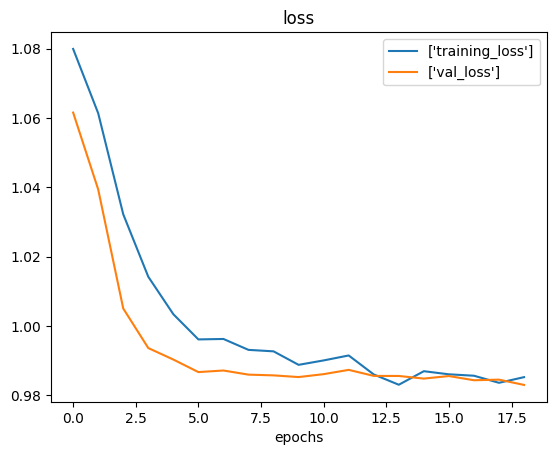

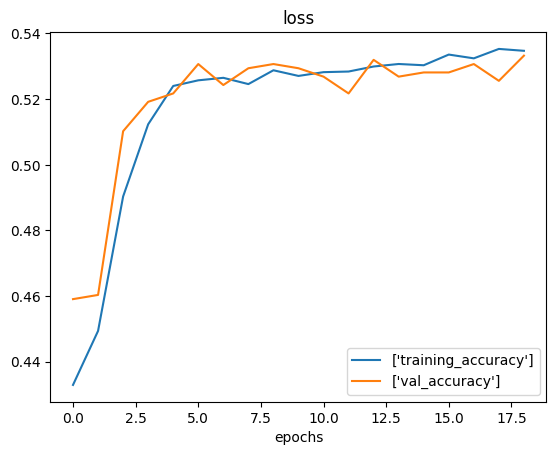

In [127]:
plot_loss_curve(history_2_best)

In [123]:
model_1_best.evaluate(Dataset_test_norm)

6/6 [==============================] - 0s 5ms/step - loss: 0.9718 - accuracy: 0.5591


[0.9718435406684875, 0.5591397881507874]

# Model_3: Conv1D

In [ ]:
def create_time_series_model_lstm(Train_teams_shape, feature_input_shape, first_dropout, 
                                   second_dropout,concat_dropout_1,concat_dropout_2, num_filters, num_features ):

    #Modello per i teams 
    inputs = layers.Input(shape=(Train_teams_shape,), name='teams_input')
    x = layers.Reshape((Train_teams_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.Conv1D(filters = 8, kernel_size=3, activation='relu')(x)
    x = layers.Flatten()(x) #layers.Flatten()(x)
    outputs = layers.Dense(8)(x)
    model_teams = tf.keras.Model(inputs,outputs, name = 'model_1_teams')

    # modello ft_goals
    inputs = layers.Input(shape=(feature_input_shape,), name='goals_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.LSTM(num_filters, return_sequences=True)(x)  
    x = layers.Flatten()(x) #layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_ft_goals = tf.keras.Model(inputs, outputs, name='model_1_goals')

    # modello ft_goals_conceded
    inputs = layers.Input(shape=(feature_input_shape,), name='goals_conceded_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.LSTM(num_filters, activation='relu', return_sequences=True)(x)
    x = layers.Flatten()(x)                
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_ft_goals_conceded = tf.keras.Model(inputs, outputs, name='ft_goals_conceded')

    # modello shots
    inputs = layers.Input(shape=(feature_input_shape,), name='shotss_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.LSTM(num_filters, return_sequences=True)(x)     
    x = layers.Flatten()(x)          
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_shots = tf.keras.Model(inputs, outputs, name='model_1_shots')

    # modello corners_obtained
    inputs = layers.Input(shape=(feature_input_shape,), name='corners_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.LSTM(num_filters, return_sequences=True)(x)               
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_corners_obtained = tf.keras.Model(inputs, outputs, name='model_1_corners_obtained')

    # se considero tutte le features inserisco anche gli shots on target e corner
    if num_features == 'all':
        # modello shots_target
        inputs = layers.Input(shape=(feature_input_shape,), name='shots_target_input')
        x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
        x = layers.LSTM(num_filters, return_sequences=True)(x)         
        x = layers.Flatten()(x)       
        x = layers.Dense(16, activation='relu')(x)
        outputs = layers.Dropout(second_dropout)(x) 
        model_shots_target = tf.keras.Model(inputs, outputs, name='model_1_shots_target')

        #Unisco i modelli dei tiri 
        model_1_shots_concat_layer = layers.Concatenate(name="shots_concat")([model_shots.output, model_shots_target.output,
                                                                               model_corners_obtained.output])
        x = layers.Dense(64, activation='relu')(model_1_shots_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
        output_layer_shots_concat = layers.Dense(32, activation='relu')(x)

        #creo il modello  finale dei tiri
        model_1_shots_concat =tf.keras.Model(
            inputs=[[ model_shots.input, model_shots_target.input, model_corners_obtained.input]],
            outputs=output_layer_shots_concat,
            name='model_1_shots_concat'
    )
    
    elif num_features=='less':
        #Unisco i modelli dei tiri 
        model_1_shots_concat_layer = layers.Concatenate(name="shots_concat")([model_shots.output,
                                                                               model_corners_obtained.output])
        x = layers.Dense(64, activation='relu')(model_1_shots_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
        output_layer_shots_concat = layers.Dense(32, activation='relu')(x)

        #creo il modello  finale dei tiri
        model_1_shots_concat =tf.keras.Model(
            inputs=[[ model_shots.input, model_corners_obtained.input]],
            outputs=output_layer_shots_concat,
            name='model_1_shots_concat'
    )

    # modello fouls_done
    inputs = layers.Input(shape=(feature_input_shape,), name='fouls_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.LSTM(num_filters, return_sequences=True)(x) 
    x = layers.Flatten()(x)              
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_fouls_done = tf.keras.Model(inputs, outputs, name='model_1_fouls_done')

    if num_features == 'all':
        # modello yellows
        inputs = layers.Input(shape=(feature_input_shape,), name='yellows_input')
        x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
        x = layers.LSTM(num_filters, return_sequences=True)(x)   
        x = layers.Flatten()(x)             
        x = layers.Dense(16, activation='relu')(x)
        outputs = layers.Dropout(second_dropout)(x) 
        model_yellows = tf.keras.Model(inputs, outputs, name='model_1_corners_yellows')

    # modello reds
    inputs = layers.Input(shape=(feature_input_shape,), name='reds_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.LSTM(num_filters, return_sequences=True)(x)  
    x = layers.Flatten()(x)             
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_reds = tf.keras.Model(inputs, outputs, name='model_1_corners_reds')

    if num_features == 'all':
            #Unisco i modelli dei falli 
        model_1_fouls_concat_layer = layers.Concatenate(name="fouls_concat")([model_fouls_done.output, model_yellows.output, model_reds.output])
        x = layers.Dense(64, activation='relu')(model_1_fouls_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
        output_layer_fouls_concat = layers.Dense(32, activation='relu')(x)

        #creo il modello  finale dei falli
        model_1_fouls_concat =tf.keras.Model(
            inputs=[[ model_fouls_done.input, model_yellows.input, model_reds.input]],
            outputs=output_layer_fouls_concat,
            name='model_1_shots_concat' 
        )

    elif num_features == 'less':
            #Unisco i modelli dei falli 
        model_1_fouls_concat_layer = layers.Concatenate(name="fouls_concat")([model_fouls_done.output, model_reds.output])
        x = layers.Dense(64, activation='relu')(model_1_fouls_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
        output_layer_fouls_concat = layers.Dense(32, activation='relu')(x)

        #creo il modello  finale dei falli
        model_1_fouls_concat =tf.keras.Model(
            inputs=[[ model_fouls_done.input, model_reds.input]],
            outputs=output_layer_fouls_concat,
            name='model_1_shots_concat' 
        )

    if ((num_features == 'all') | (num_features=='less')):
        #Unisco i modelli 
        model_1_concat_layer = layers.Concatenate(name="feature_concat")([ model_teams.output, model_ft_goals.output, model_ft_goals_conceded.output, 
                                                                model_1_shots_concat.output, model_1_fouls_concat.output])
        x = layers.Dense(64, activation='relu')(model_1_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(concat_dropout_2)(x)
        output_layer = layers.Dense(3, activation = 'softmax')(x)

    else:
        #Unisco i modelli 
        model_1_concat_layer = layers.Concatenate(name="feature_concat")([ model_teams.output, model_ft_goals.output, model_ft_goals_conceded.output, 
                                                                model_shots.output, model_reds.output])
        x = layers.Dense(64, activation='relu')(model_1_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(concat_dropout_2)(x)
        output_layer = layers.Dense(3, activation = 'softmax')(x)


    #creo il modello  finale
    if num_features == 'all':
        model_1_final =tf.keras.Model(
            inputs=[[model_teams.input, model_ft_goals.input, model_ft_goals_conceded.input, model_shots.input, model_shots_target.input, model_fouls_done.input, 
                        model_corners_obtained.input, model_yellows.input, model_reds.input]],
            outputs=output_layer,
            name='model_1_dense_concat'
        )

    if num_features == 'less':
        model_1_final =tf.keras.Model(
            inputs=[[model_teams.input, model_ft_goals.input, model_ft_goals_conceded.input, model_shots.input, model_fouls_done.input, 
                        model_corners_obtained.input, model_reds.input]],
            outputs=output_layer,
            name='model_1_dense_concat'
        )
    
    if num_features == 'few':
        model_1_final =tf.keras.Model(
            inputs=[[model_teams.input, model_ft_goals.input, model_ft_goals_conceded.input, model_shots.input, model_reds.input]],
            outputs=output_layer,
            name='model_1_dense_concat'
        )
    return model_1_final
